# Milestone P1 Energy/Latency Analysis

This notebook loads the experimental results from `data/latency_results.csv` and `data/power_logs.csv` and visualizes the trade-offs between CPU and GPU backends.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
latency_df = pd.read_csv("../../data/latency_results.csv")
power_df = pd.read_csv("../../data/power_logs.csv")

# Convert timestamps
latency_df["timestamp"] = pd.to_datetime(latency_df["timestamp"])
power_df["timestamp"] = pd.to_datetime(power_df["timestamp"])

# Filter for recent runs (Nov 2025)
cutoff_date = pd.Timestamp("2025-11-01")
latency_df = latency_df[latency_df["timestamp"] > cutoff_date]
power_df = power_df[power_df["timestamp"] > cutoff_date]

print(f"Loaded {len(latency_df)} latency records and {len(power_df)} power records.")

Loaded 145 latency records and 32 power records.


In [2]:
# 2. Aggregate Data
# Group latency by backend and suite
lat_summary = latency_df.groupby(["backend", "prompt_template"])["latency_ms"].mean().reset_index()

# Helper to extract suite from power notes
def map_id_to_suite(note):
    if "sd-" in note: return "short_dialogue"
    if "ar-" in note: return "analytical_reasoning"
    if "ng-" in note: return "narrative_generation"
    return "unknown"

power_df["suite"] = power_df["notes"].apply(map_id_to_suite)
pow_summary = power_df.groupby(["backend", "suite"])["energy_joules"].mean().reset_index()

# Merge
merged = pd.merge(
    lat_summary, 
    pow_summary, 
    left_on=["backend", "prompt_template"], 
    right_on=["backend", "suite"]
)
merged

,backend,prompt_template,latency_ms,suite,energy_joules
0,cpu,analytical_reasoning,2184.876600,analytical_reasoning,212.779031
1,cpu,narrative_generation,5175.106905,narrative_generation,208.196809
2,cpu,short_dialogue,2646.850370,short_dialogue,189.687303
3,gpu,analytical_reasoning,1115.802000,analytical_reasoning,158.631167
4,gpu,narrative_generation,5058.552000,narrative_generation,176.540867
5,gpu,short_dialogue,1269.345963,short_dialogue,158.727533


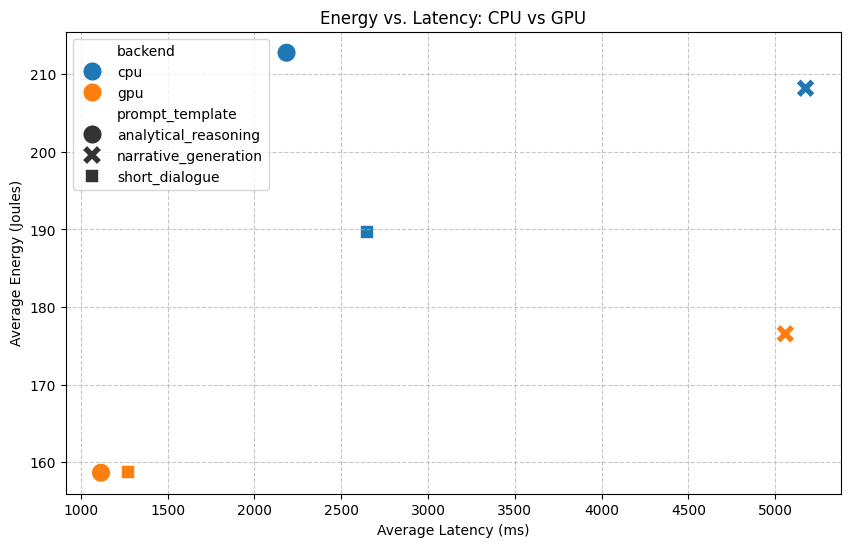

In [3]:
# 3. Visualize Results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged, 
    x="latency_ms", 
    y="energy_joules", 
    hue="backend", 
    style="prompt_template", 
    s=200
)

plt.title("Energy vs. Latency: CPU vs GPU")
plt.xlabel("Average Latency (ms)")
plt.ylabel("Average Energy (Joules)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()